In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import keras
from tensorflow.keras.layers import Dropout,BatchNormalization,LSTM,Bidirectional,GlobalMaxPool1D,Input,Activation,Flatten,Embedding,Dense,concatenate,Conv1D,MaxPooling1D
import string
import re
from tqdm import tqdm
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,classification_report
import os
from tensorflow.keras.models import Model
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')
import tensorboard
from textblob import TextBlob
import os
import tensorboard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from transformers import TFBertModel, BertTokenizer
import nltk

2022-08-06 06:36:35.875395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 06:36:35.876560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 06:36:35.877249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 06:36:35.879099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [5]:
data=pd.read_csv("../input/sarcasm/train-balanced-sarcasm.csv")
data.shape

(1010826, 10)

In [6]:
null_values=data.isna().sum()
print(null_values)

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64


In [7]:
data=data.dropna()
data.isna().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [8]:
duplicate_values=data[data.duplicated()]
print("duplicate rows in the dataset",len(duplicate_values))
data.drop_duplicates(keep='first',inplace=True)

duplicate rows in the dataset 28


In [9]:
data['score']=data['ups']-data['downs']

In [10]:
data.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,0,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,0,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,0,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,0,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [11]:
null_values=data.isna().sum()
print(null_values)

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64


In [12]:
data=data.dropna()
data.isna().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [13]:
duplicate_values=data[data.duplicated()]
print("duplicate rows in the dataset",len(duplicate_values))
data.drop_duplicates(keep='first',inplace=True)

duplicate rows in the dataset 4


In [14]:
# slangs
strings='''AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA?=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher'''

In [15]:
x1=strings.split("\n")
dict1={}
for i in x1:
    x2=(i.split("="))
    dict1[x2[0]]=x2[1]
print(dict1)

{'AFAIK': 'As Far As I Know', 'AFK': 'Away From Keyboard', 'ASAP': 'As Soon As Possible', 'ATK': 'At The Keyboard', 'ATM': 'At The Moment', 'A3': 'Anytime, Anywhere, Anyplace', 'BAK': 'Back At Keyboard', 'BBL': 'Be Back Later', 'BBS': 'Be Back Soon', 'BFN': 'Bye For Now', 'B4N': 'Bye For Now', 'BRB': 'Be Right Back', 'BRT': 'Be Right There', 'BTW': 'By The Way', 'B4': 'Before', 'CU': 'See You', 'CUL8R': 'See You Later', 'CYA': 'See You', 'FAQ': 'Frequently Asked Questions', 'FC': 'Fingers Crossed', 'FWIW': "For What It's Worth", 'FYI': 'For Your Information', 'GAL': 'Get A Life', 'GG': 'Good Game', 'GN': 'Good Night', 'GMTA': 'Great Minds Think Alike', 'GR8': 'Great!', 'G9': 'Genius', 'IC': 'I See', 'ICQ': 'I Seek you (also a chat program)', 'ILU': 'ILU: I Love You', 'IMHO': 'In My Honest/Humble Opinion', 'IMO': 'In My Opinion', 'IOW': 'In Other Words', 'IRL': 'In Real Life', 'KISS': 'Keep It Simple, Stupid', 'LDR': 'Long Distance Relationship', 'LMAO': 'Laugh My A.. Off', 'LOL': 'Laug

In [16]:
def chat(text):
    new_text=[]
    for word in text.split():
        if word.upper() in dict1:
            new_text.append(dict1[word.upper()])
        else:
            new_text.append(word)
            
    done=" ".join(new_text)

            
    return done
            

In [17]:
data['comment']=data['comment'].apply(chat)

In [18]:
#decontract words
def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [19]:
data['comment']=data['comment'].apply(decontracted)

In [20]:
# lower case
data['comment']=data['comment'].str.lower()

In [21]:
# removing stopwords

# we have removed stopwords like no,not,nor.
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
            "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", 
            "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", 
            "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
            "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but",
            "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", 
            "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", 
            "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", 
            "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few",
            "more", "most", "other", "some", "such" "only", "own", "same", "so", "than", "too", "very", 
            "s", "t", "can", "will", "just", "don", "should", "now"]

In [22]:
def stopwords1(text):
    new_list=[]
    for word in text.split():
        if word in stop_words:
            new_list.append("")
        else:
            new_list.append(word)

    done=list(filter(None,new_list))
    done=" ".join(done)
    
    return done

In [23]:
data['comment']=data['comment'].apply(stopwords1)

In [24]:
# remove html tags
def remove_html(text):
    return re.sub(r'<.*?>',"",text)

In [25]:
data['comment']=data['comment'].apply(remove_html)

In [26]:
# removing digits
def remove_numbers(text):
    return re.sub("\d+", "", text)

In [27]:
data['comment']=data['comment'].apply(remove_numbers)

In [28]:
string1=string.punctuation
string1=list(string1)
string1.remove('!')
string1.remove('?')
print(string1)

['"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [29]:
def remove_punctuation(data):
    for char in string1:
        if char in data:
            data=data.replace(char," ")
    return data

In [30]:
data['comment']=data['comment'].apply(remove_punctuation)

In [31]:
# data_basic=data.drop(['author','score','ups','downs','date','created_utc','parent_comment','subreddit'],axis=1)

In [5]:
data_new=pd.read_csv('../input/data-pre-1/data_preprocessed.csv')
data_new1=data_new.drop(['Unnamed: 0'],axis=1)
data_new1=data_new1.dropna()

In [6]:
df_small=data_new1.sample(100000)

In [7]:
df_small.head()

,label,comment,exclamation_mark,question_mark,sentiment_subjectivity,sentiment_positive,sentiment_negative,sentiment_neutral,profane_words
27463,0,sunanda tharoor?,0,1,0.211111,0.00,0.500,0.500,0.0
1006448,1,almost got death panels too!,1,0,0.500000,0.48,0.423,0.096,0.0
438113,1,easiest way buy two ps is ps link cable cop...,0,0,0.000000,0.00,0.252,0.748,0.0
141519,1,behavior justifies killing someone,0,0,0.100000,0.00,0.000,1.000,0.0
384845,0,jesus christ chance,0,0,0.800000,0.00,0.000,1.000,0.0


In [9]:
y=data['label']
X=data['comment']

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42,test_size=0.2,shuffle=True)
print((X_train.shape),y_train.shape)
print((X_test.shape),y_test.shape)

(808596,) (808596,)
(202149,) (202149,)


In [11]:
bert_model=TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [12]:
def text_encoding(tokenizer, texts, max_length, batch_size=512):
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_len, padding='max_length',
                                             truncation=True, return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])        
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [13]:
max_len = 40
X_train_ids, X_train_attention = text_encoding(bert_tokenizer, X_train.tolist(),max_len)
X_test_ids, X_test_attention = text_encoding(bert_tokenizer, X_test.tolist(), max_len)

In [14]:
for layer in bert_model.layers:
    layer.trainable=False

In [38]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [15]:
def model_architecture():
    # Model architecture

    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)

    # DistilBERT Layers
    input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
    input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
    last_hidden_state = bert_model(input_ids_layer,input_attention_layer)[1]
#     cls_token = last_hidden_state[:, 0, :]

    # NN layer
    
    X = Dropout(0.3)(last_hidden_state )
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(16, activation='relu')(X)
    
    output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(X)

    model_bert = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)
    
    return model_bert

In [16]:
model_bert=model_architecture()
# model_bert.layers[2].trainable=True

In [17]:
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 768)          0           tf_bert_model[0][1]          

In [28]:
# optimizer= tf.keras.optimizers.Adam(lr = 5e-6 , epsilon = 1e-7 , decay  = 0.01 , clipnorm = 1.0)

In [18]:
model_bert.compile(loss='binary_crossentropy',optimizer=Adam(lr=3e-5),metrics=['accuracy'])

In [19]:
Epochs=5
Batch_size=512
model_bert_results = model_bert.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = ([X_test_ids, X_test_attention], y_test))

Epoch 1/5


2022-08-06 06:46:04.102029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1580/1580 [==============================] - 1398s 878ms/step - loss: 0.6946 - accuracy: 0.5135 - val_loss: 0.6856 - val_accuracy: 0.5840
Epoch 2/5
1580/1580 [==============================] - 1383s 876ms/step - loss: 0.6855 - accuracy: 0.5484 - val_loss: 0.6696 - val_accuracy: 0.6026
Epoch 3/5
1580/1580 [==============================] - 1383s 875ms/step - loss: 0.6779 - accuracy: 0.5714 - val_loss: 0.6575 - val_accuracy: 0.6151
Epoch 4/5
1580/1580 [==============================] - 1384s 876ms/step - loss: 0.6720 - accuracy: 0.5842 - val_loss: 0.6516 - val_accuracy: 0.6248
Epoch 5/5
1580/1580 [==============================] - 1384s 876ms/step - loss: 0.6681 - accuracy: 0.5911 - val_loss: 0.6488 - val_accuracy: 0.6253


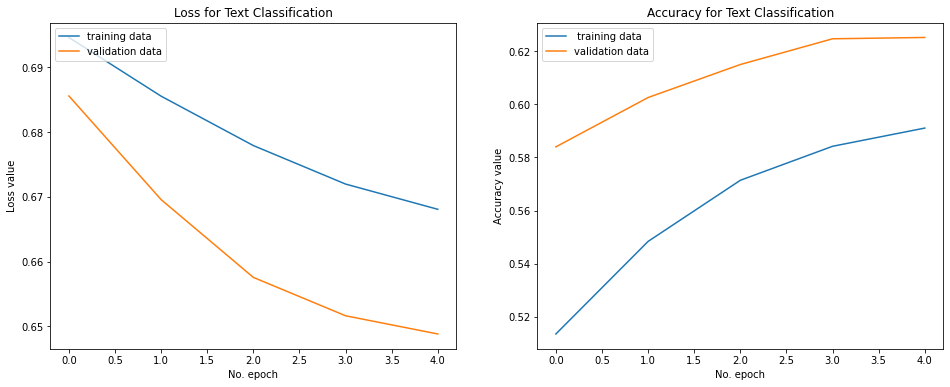

In [24]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_bert_results.history['loss'], label='training data')
plt.plot(model_bert_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_bert_results.history['accuracy'], label=' training data')
plt.plot(model_bert_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [25]:
val_pred=model_bert.predict([X_test_ids,X_test_attention])
val_pred=np.where(val_pred>0.5, 1, 0)

In [27]:
f1_score(y_test, val_pred)

0.6453132315759902

In [29]:
# Load the library
from tensorflow.keras.models import load_model
# Save the model
model_bert.save('.//model_bert_base.h5')